In [23]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pickle
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv(r"./data/ingredients.csv")
article = open("./data/article.txt", "r")
article = article.read()

In [3]:
df.head()

,Title,Description
0,'Ambrette Seed',"Ambrette is a plant. The seed of the plant, ty..."
1,'Apple Cinnamon Granola',"Packed with rolled oats, almonds, sunflower se..."
2,'Arizona Seasoning',Arizona Dreaming is simply a delicious all-pur...
3,Americano Coffee',Type of coffee drink prepared by diluting an e...
4,'Baby Abalone',is a common name for any of a group of small ...


In [4]:
df.iloc[:,1] = df.iloc[:,1]*1000

In [5]:
stop_words = set(stopwords.words('english')) 
stop_words.update('.',',','(',')','!',';','%')

In [6]:
for i in range(len(df)):
    word_tokens = word_tokenize(df.loc[i][1])
  
    filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]
    
    filtered_sentence = []
    
    for w in word_tokens:
        if w not in stop_words:
            filtered_sentence.append(w)
        
    filtered_sentence = ' '.join(filtered_sentence)

    df.iloc[i][1] = filtered_sentence

word_tokens = word_tokenize(article)

filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]
    
filtered_sentence = []

for w in word_tokens:
    if w not in stop_words:
        filtered_sentence.append(w)
    
filtered_sentence = ' '.join(filtered_sentence)

article = filtered_sentence

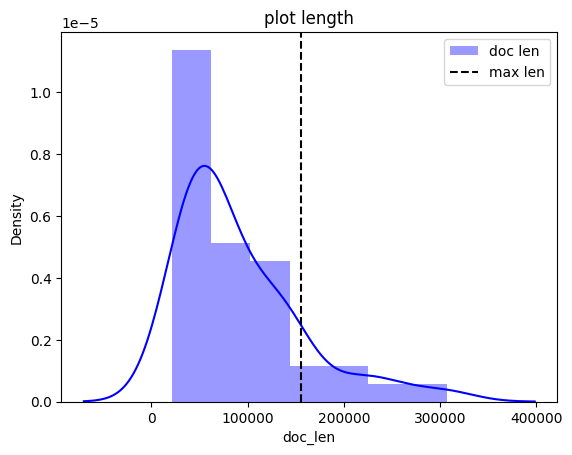

In [7]:
df['doc_len'] = df['Description'].apply(lambda words: len(words.split()))
max_seq_len = np.round(df['doc_len'].mean() + df['doc_len'].std()).astype(int)
sns.distplot(df['doc_len'], hist=True, kde=True, color='b', label='doc len')
plt.axvline(x=max_seq_len, color='k', linestyle='--', label='max len')
plt.title('plot length'); plt.legend()
plt.show()

In [26]:
import sentence_transformers
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('msmarco-roberta-base-v3')

In [31]:
import faiss
encoded_data = model.encode(df.Description.tolist())
encoded_data = np.asarray(encoded_data.astype('float32')).astype('float32')
index = faiss.IndexIDMap(faiss.IndexFlatIP(768))
index.add_with_ids(encoded_data, (np.array(range(0, len(df))).astype('int64')))

In [32]:
def fetch_movie_info(dataframe_idx):
    info = df.iloc[dataframe_idx]
    meta_dict = dict()
    meta_dict['Title'] = info['Title']
    return meta_dict
    
def search(query, top_k, index, model):
    t=time.time()
    query_vector = model.encode([query])
    top_k = index.search(query_vector, top_k)
    print('>>>> Results in Total Time: {}'.format(time.time()-t))
    top_k_ids = top_k[1].tolist()[0]
    results =  [fetch_movie_info(idx) for idx in top_k_ids]
    return results

In [33]:
query=article
results=search(query, top_k=5, index=index, model=model)
print("\n")
for result in results:
    print('\t',result)

>>>> Results in Total Time: 0.8541176319122314


	 {'Title': "Vegan Chicken Strips'"}
	 {'Title': "'Hog Maw'"}
	 {'Title': "'Muesli'"}
	 {'Title': "'Apple Cinnamon Granola'"}
	 {'Title': "Vegan Marshmallow'"}


In [30]:
pickle.dump(model, open("./models/msmarco-roberta-base-v3", "wb"))

In [15]:
from sentence_transformers import SentenceTransformer, InputExample, losses, models, datasets

word_emb = models.Transformer('sentence-transformers/msmarco-distilbert-base-dot-prod-v3')
pooling = models.Pooling(word_emb.get_word_embedding_dimension())
model = SentenceTransformer(modules=[word_emb, pooling])

In [17]:
df.head()

,Title,Description,doc_len
0,'Ambrette Seed',Ambrette plant The seed plant typically prepar...,73001
1,'Apple Cinnamon Granola',Packed rolled oats almonds sunflower seeds pum...,134001
2,'Arizona Seasoning',Arizona Dreaming simply delicious all-purpose ...,63001
3,Americano Coffee',Type coffee drink prepared diluting espresso h...,89001
4,'Baby Abalone',common name group small large marine gastropod...,126000


In [18]:
from torch import nn
import os

train_examples = [] 
for i in range(len(df)):
    query = df.loc[i][0]
    paragraph = df.loc[i][1]
    try:
        # paragraph = paragraph.split(" ")
        train_examples.append(InputExample(texts=[query, paragraph]))
    except:
        pass

In [19]:
train_dataloader = datasets.NoDuplicatesDataLoader(train_examples, batch_size=8)
train_loss = losses.MultipleNegativesRankingLoss(model)

In [20]:
num_epochs = 3
warmup_steps = int(len(train_dataloader) * num_epochs * 0.1)
model.fit(train_objectives=[(train_dataloader, train_loss)], epochs=num_epochs, warmup_steps=warmup_steps, show_progress_bar=True)

os.makedirs('search', exist_ok=True)
model.save('search/search-model')

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Iteration:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/5 [00:00<?, ?it/s]

In [21]:
def fetch_movie_info(dataframe_idx):
    info = df.iloc[dataframe_idx]
    meta_dict = dict()
    meta_dict['Title'] = info['Title']
    #meta_dict['Description'] = info['Description'][:5000]
    return meta_dict
    
def search(query, top_k, index, model):
    t=time.time()
    query_vector = model.encode([query])
    top_k = index.search(query_vector, top_k)
    print('>>>> Results in Total Time: {}'.format(time.time()-t))
    top_k_ids = top_k[1].tolist()[0]
    # top_k_ids = list(np.unique(top_k_ids))
    results =  [fetch_movie_info(idx) for idx in top_k_ids]
    return results

In [22]:
query=article
results=search(query, top_k=5, index=index, model=model)
print("\n")
for result in results:
    print('\t',result)

>>>> Results in Total Time: 0.4603574275970459


	 {'Title': "Organic Maize'"}
	 {'Title': "'Mulberry'"}
	 {'Title': "Peanut Butter'"}
	 {'Title': "'Ambrette Seed'"}
	 {'Title': "Salmon'"}


In [25]:
pickle.dump(model, open("./models/msmarco-distilbert-base-dot-prod-v3", "wb"))